In [16]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import pandas as pd
import numpy as np

from utils.data_utils.data_handler import Handler
from utils.data_utils.data_transform import DataTransform
from portfolio.portfolio import Portfolio
from backtest.backtest import Backtest

import time

from glob import glob
import shutil
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
benchmark_csv_dir = '../data/benchmark/dc_performance.csv'
fundamental_csv_dir = '../data/fundamental_data/'
historical_csv_dir = '../data/historical_data/'
gics_csv_dir = '../data/gics/gics.csv'

handl = Handler(benchmark_csv_dir, fundamental_csv_dir, historical_csv_dir, gics_csv_dir)

In [18]:
benchmark = handl.get_benchmark_data() 
fun_data = handl.get_processed_fundamental_data() 
hist_data = handl.get_processed_historical_data() 

In [19]:
transform = DataTransform(benchmark, fun_data, hist_data, start_time='2013-01-01')

In [20]:
long_daily, long_monthly = transform.get_transform_data()

/root/quant-trading/principle-component-mommentum/notebooks/../src/utils/data_utils/data_transform.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  long_daily['r'] = long_daily.groupby(level=1)['close'].ffill().transform(lambda x: x.pct_change())
/root/quant-trading/principle-component-mommentum/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
# past_formation_dfs, future_holding_dfs = transform.get_rolling_df()

In [ ]:
portf= Portfolio(long_daily, long_monthly)

In [ ]:
bt = Backtest(portfolio=portf)

In [9]:
bt.run()

Backtest is running ...
|████████████████████████████████████████| 121/121 [100%] in 3:16.6 (0.61/s)    


In [10]:
cum_top_ret_w = pd.DataFrame(bt.cum_top_excess_w_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'])
cum_top_ret_l = pd.DataFrame(bt.cum_top_excess_l_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'])
cum_top_ret_arb = pd.DataFrame(bt.cum_top_excess_arb_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'])

cum_bottom_ret_w = pd.DataFrame(bt.cum_bottom_excess_w_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'])
cum_bottom_ret_l = pd.DataFrame(bt.cum_bottom_excess_l_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'])
cum_bottom_ret_arb = pd.DataFrame(bt.cum_bottom_excess_arb_ret, columns=['CMOM', 'MMOM', 'TMOM', 'PMOM'])

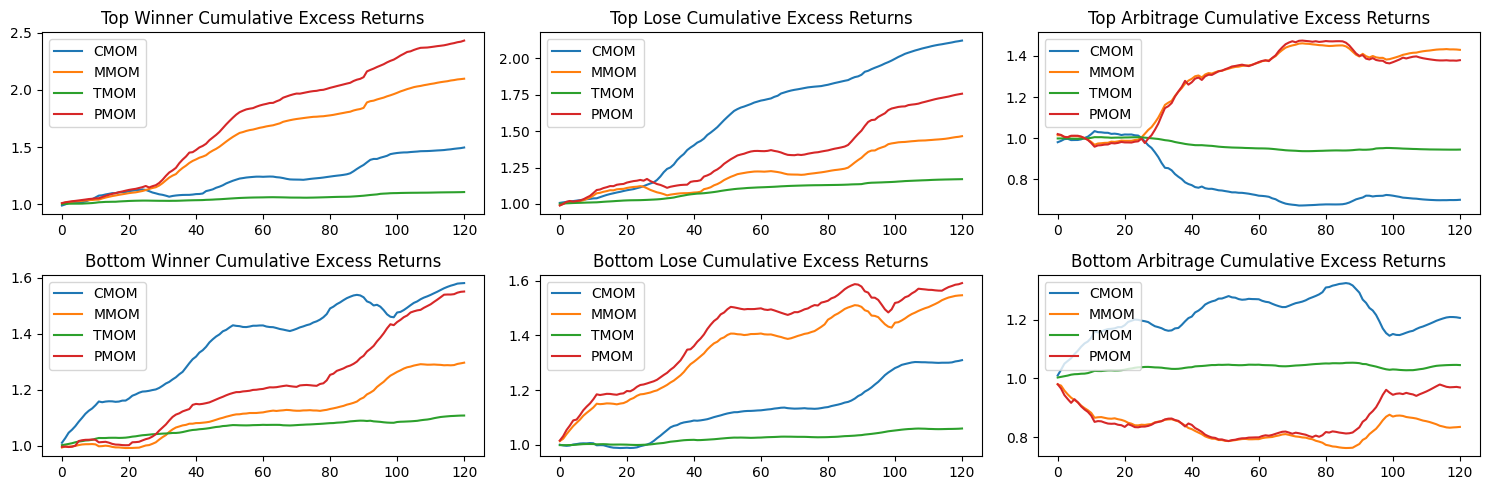

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 5))

(cum_top_ret_w.div(100).add(1).cumprod()).plot(ax=axes[0, 0], title='Top Winner Cumulative Excess Returns')
(cum_top_ret_l.div(100).add(1).cumprod()).plot(ax=axes[0, 1], title='Top Lose Cumulative Excess Returns')
(cum_top_ret_arb.div(100).add(1).cumprod()).plot(ax=axes[0, 2], title='Top Arbitrage Cumulative Excess Returns')

(cum_bottom_ret_w.div(100).add(1).cumprod()).plot(ax=axes[1, 0], title='Bottom Winner Cumulative Excess Returns')
(cum_bottom_ret_l.div(100).add(1).cumprod()).plot(ax=axes[1, 1], title='Bottom Lose Cumulative Excess Returns')
(cum_bottom_ret_arb.div(100).add(1).cumprod()).plot(ax=axes[1, 2], title='Bottom Arbitrage Cumulative Excess Returns')

plt.tight_layout()

plt.savefig("size_portfolio_cummulative_excess_ret.jpg", format='png', dpi=400)

plt.show()


In [26]:
time_list = pd.concat(future_holding_dfs).index.tolist()

In [29]:
performance_iter = [time_list,
                    ["top", "bottom"], 
                    ["winner", "loser", "arbitrage"]]
idx = pd.MultiIndex.from_product(performance_iter, names=["time", "size", "type"])

In [12]:
df = pd.read_csv('../data/historical_data/LPB.csv')

<Axes: >

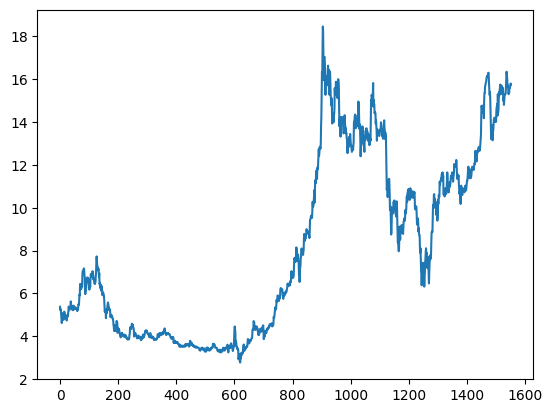

In [16]:
df.close.plot()